# Preprocessing Validation - Missing Value Handling

This notebook validates the missing value handling strategy implemented in `src/data/preprocessing.py`.

**Objectives:**
- Compare dataset characteristics before and after preprocessing
- Verify that missing values were handled correctly
- Check that data distributions were preserved during imputation
- Validate that no data quality issues were introduced

**Files analyzed:**
- Input: `openfoodfacts_filtered.csv` (with missing values)
- Output: `openfoodfacts_preprocessed.csv` (after handling missing values)
- Report: `imputation_report.json` (detailed documentation)

In [1]:
# Import required libraries
import pandas as pd           # Data manipulation and analysis
import numpy as np             # Numerical operations
import matplotlib.pyplot as plt # Plotting
import seaborn as sns          # Statistical visualizations
import json                    # Reading JSON report

# Configure visualization style for cleaner plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)  # Default figure size

## 1. Load Data

Load both the original filtered dataset and the preprocessed dataset to compare them. Also load the JSON report that documents all imputation decisions.

In [2]:
# Load the dataset BEFORE preprocessing (contains missing values)
df_before = pd.read_csv('../data/processed/openfoodfacts_filtered.csv')

# Load the dataset AFTER preprocessing (missing values handled)
df_after = pd.read_csv('../data/processed/openfoodfacts_preprocessed.csv')

# Load the imputation report (contains strategy and statistics)
with open('../data/processed/imputation_report.json', 'r') as f:
    imputation_report = json.load(f)

# Display basic information about dataset dimensions
print(f"Before preprocessing: {df_before.shape}")
print(f"After preprocessing: {df_after.shape}")

Before preprocessing: (100000, 22)
After preprocessing: (100000, 20)


## 2. Missing Values Comparison

Calculate and compare missing value counts and percentages for each feature before and after preprocessing. This helps verify that the preprocessing step successfully addressed all missing data.

In [3]:
# Count missing values in each dataset
missing_before = df_before.isnull().sum()  # Number of missing values per column (before)
missing_after = df_after.isnull().sum()     # Number of missing values per column (after)

# Create a comparison table with counts and percentages
comparison = pd.DataFrame({
    'Before (count)': missing_before,
    'Before (%)': (missing_before / len(df_before)) * 100,
    'After (count)': missing_after if len(missing_after) > 0 else 0,
    'After (%)': (missing_after / len(df_after)) * 100 if len(missing_after) > 0 else 0
})

# Filter to show only columns that had missing values before preprocessing
# Sort by missing percentage (descending) to see worst cases first
comparison_filtered = comparison[comparison['Before (count)'] > 0].sort_values('Before (%)', ascending=False)

print("\nMissing Values Comparison:")
print("="*70)
print(comparison_filtered)


Missing Values Comparison:
                                      Before (count)  Before (%)  \
fruits-vegetables-nuts-estimate_100g           99077      99.077   
fruits-vegetables-nuts_100g                    98892      98.892   
fiber_100g                                     44579      44.579   
additives_n                                    34112      34.112   
brands                                         21429      21.429   
energy-kcal_100g                                4353       4.353   
saturated-fat_100g                              4058       4.058   
sugars_100g                                     2495       2.495   
carbohydrates_100g                              1792       1.792   
proteins_100g                                   1680       1.680   
fat_100g                                        1678       1.678   
energy_100g                                     1675       1.675   
salt_100g                                       1635       1.635   
sodium_100g         

C:\Users\cesar\AppData\Local\Temp\ipykernel_2384\1231481873.py:28: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
d:\conda\envs\machine_learning_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


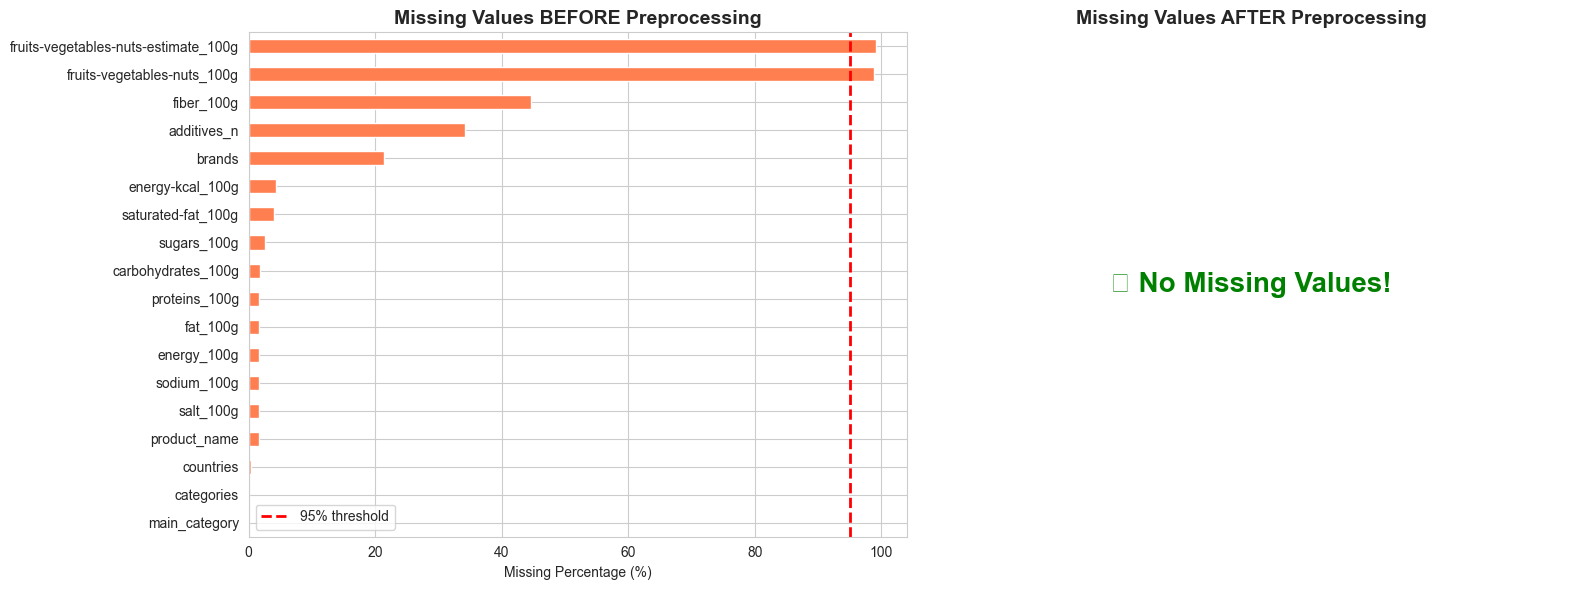

In [4]:
# Create side-by-side bar charts to visualize missing values before and after
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Missing values BEFORE preprocessing
missing_pct_before = (missing_before / len(df_before)) * 100
missing_pct_before = missing_pct_before[missing_pct_before > 0].sort_values(ascending=True)
missing_pct_before.plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Missing Values BEFORE Preprocessing', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Missing Percentage (%)')
# Add red line at 95% threshold (features above this were dropped)
axes[0].axvline(95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[0].legend()

# RIGHT PLOT: Missing values AFTER preprocessing
if df_after.isnull().sum().sum() > 0:
    # If there are still missing values, plot them
    missing_pct_after = (missing_after / len(df_after)) * 100
    missing_pct_after = missing_pct_after[missing_pct_after > 0].sort_values(ascending=True)
    missing_pct_after.plot(kind='barh', ax=axes[1], color='lightgreen')
    axes[1].set_title('Missing Values AFTER Preprocessing', fontsize=14, fontweight='bold')
else:
    # If no missing values remain, show success message
    axes[1].text(0.5, 0.5, 'No Missing Values!', 
                ha='center', va='center', fontsize=20, color='green', fontweight='bold')
    axes[1].set_title('Missing Values AFTER Preprocessing', fontsize=14, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Imputation Statistics

Display the detailed imputation strategy used for each feature. The report shows:
- **Method**: The imputation technique (median, constant, etc.)
- **Value**: The actual value used for imputation
- **Missing count**: How many values were imputed
- **Rationale**: Why this strategy was chosen

In [5]:
# Extract imputation statistics from the JSON report
# This dictionary contains details about how each feature was imputed
imputation_stats = imputation_report['imputation_statistics']

print("\nImputation Strategy Summary:")
print("="*70)

# Iterate through each imputed feature and display its strategy
for col, stats in imputation_stats.items():
    print(f"\n{col}:")
    print(f"  Method: {stats['method']}")           # Technique used (median, constant)
    print(f"  Value: {stats['value']}")              # Imputation value
    print(f"  Missing count: {stats['missing_count']:,}")  # Number of values filled
    print(f"  Rationale: {stats['rationale']}")     # Explanation for strategy choice


Imputation Strategy Summary:

energy_100g:
  Method: median
  Value: 1084.0
  Missing count: 1,675
  Rationale: Median imputation for nutritional values

energy-kcal_100g:
  Method: median
  Value: 261.0
  Missing count: 4,353
  Rationale: Median imputation for nutritional values

fat_100g:
  Method: median
  Value: 7.69
  Missing count: 1,678
  Rationale: Median imputation for nutritional values

saturated-fat_100g:
  Method: median
  Value: 2.0
  Missing count: 4,058
  Rationale: Median imputation for nutritional values

carbohydrates_100g:
  Method: median
  Value: 15.0
  Missing count: 1,792
  Rationale: Median imputation for nutritional values

sugars_100g:
  Method: median
  Value: 3.5714285714286
  Missing count: 2,495
  Rationale: Median imputation for nutritional values

fiber_100g:
  Method: median
  Value: 1.6
  Missing count: 44,579
  Rationale: Median imputation for nutritional values

proteins_100g:
  Method: median
  Value: 6.1
  Missing count: 1,680
  Rationale: Median

## 4. Distribution Comparison (Key Features)

Verify that imputation preserved the original data distributions. This is important because:
- Median imputation should not significantly alter the distribution shape
- If distributions change dramatically, it may indicate imputation introduced bias

We compare histograms of features before (excluding missing) and after (with imputed values) preprocessing.

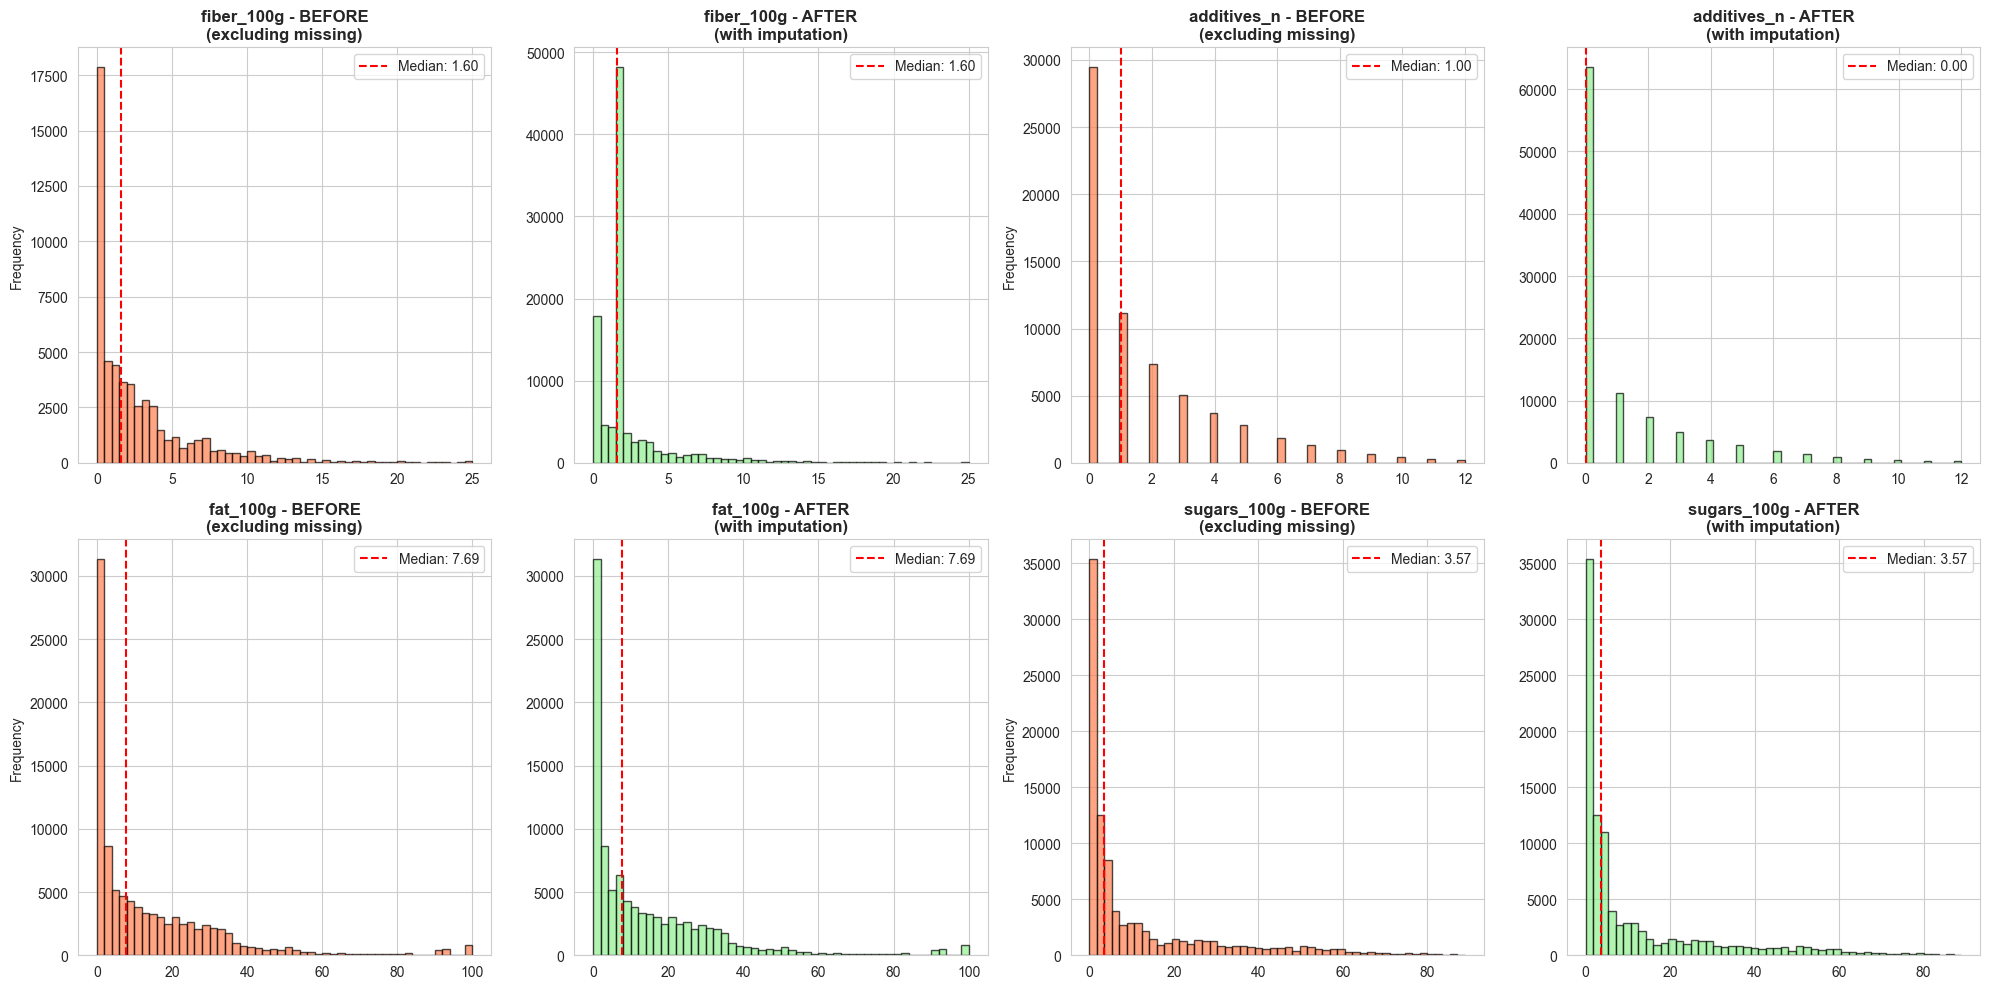

In [6]:
# Select key features that had significant missing values for comparison
key_features = ['fiber_100g', 'additives_n', 'fat_100g', 'sugars_100g']

# Create a grid of subplots: 2 plots per feature (before and after)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()  # Flatten to 1D array for easier indexing

# Generate comparison histograms for each feature
for idx, feature in enumerate(key_features):
    if feature in df_before.columns and feature in df_after.columns:
        
        # BEFORE: Get non-missing values only
        data_before = df_before[feature].dropna()
        
        # Filter extreme outliers using 99th percentile for better visualization
        q99 = data_before.quantile(0.99)
        data_before_filtered = data_before[data_before <= q99]
        
        # Plot BEFORE distribution (left plot for each feature)
        data_before_filtered.hist(bins=50, ax=axes[idx*2], alpha=0.7, color='coral', edgecolor='black')
        axes[idx*2].set_title(f'{feature} - BEFORE\n(excluding missing)', fontweight='bold')
        axes[idx*2].set_ylabel('Frequency')
        # Show median line
        axes[idx*2].axvline(data_before.median(), color='red', linestyle='--', 
                           label=f'Median: {data_before.median():.2f}')
        axes[idx*2].legend()
        
        # AFTER: Get all values (including imputed)
        data_after = df_after[feature]
        data_after_filtered = data_after[data_after <= q99]
        
        # Plot AFTER distribution (right plot for each feature)
        data_after_filtered.hist(bins=50, ax=axes[idx*2+1], alpha=0.7, color='lightgreen', edgecolor='black')
        axes[idx*2+1].set_title(f'{feature} - AFTER\n(with imputation)', fontweight='bold')
        # Show median line
        axes[idx*2+1].axvline(data_after.median(), color='red', linestyle='--', 
                             label=f'Median: {data_after.median():.2f}')
        axes[idx*2+1].legend()

plt.tight_layout()
plt.show()

## 5. Dropped Features

List features that were dropped due to excessive missing values (>95% threshold). Features with very high missing rates provide little useful information and can be safely removed.

In [7]:
# Extract list of dropped features from the report
dropped_features = imputation_report['dropped_features']

print("\nDropped Features (>95% missing):")
print("="*70)

# Display each dropped feature with its missing percentage
for feature in dropped_features:
    missing_info = imputation_report['missing_value_analysis'][feature]
    print(f"  - {feature:45s} ({missing_info['missing_percentage']:.2f}% missing)")

print(f"\nTotal features dropped: {len(dropped_features)}")


Dropped Features (>95% missing):
  - fruits-vegetables-nuts-estimate_100g          (99.08% missing)
  - fruits-vegetables-nuts_100g                   (98.89% missing)

Total features dropped: 2


## 6. Final Validation

Perform final checks to ensure preprocessing was successful:
- Verify data retention (no unexpected row loss)
- Confirm all missing values were eliminated
- Check that target variable has no missing values
- Validate data types are appropriate

In [8]:
# Perform comprehensive validation checks
print("\nFinal Validation:")
print("="*70)

# Check 1: Data retention - verify we didn't lose rows unexpectedly
print(f"Rows retained: {len(df_after):,} / {len(df_before):,} ({len(df_after)/len(df_before)*100:.2f}%)")

# Check 2: Column count - some may be dropped due to high missing rate
print(f"Columns retained: {len(df_after.columns)} / {len(df_before.columns)}")

# Check 3: Missing values - should be zero
print(f"Missing values remaining: {df_after.isnull().sum().sum()}")

# Check 4: Target variable - must have no missing values for modeling
print(f"Target variable complete: {df_after['nutriscore_grade'].notna().all()}")

# Display data types to ensure they are appropriate
print("\nData Types:")
print(df_after.dtypes)


Final Validation:
Rows retained: 100,000 / 100,000 (100.00%)
Columns retained: 20 / 22
Missing values remaining: 0
Target variable complete: True

Data Types:
nutriscore_grade       object
code                   object
product_name           object
brands                 object
categories             object
countries              object
energy_100g           float64
energy-kcal_100g      float64
fat_100g              float64
saturated-fat_100g    float64
carbohydrates_100g    float64
sugars_100g           float64
fiber_100g            float64
proteins_100g         float64
salt_100g             float64
sodium_100g           float64
additives_n           float64
pnns_groups_1          object
pnns_groups_2          object
main_category          object
dtype: object


## Summary

### Strategy Applied

Based on missing percentage thresholds, the following approaches were used:

1. **High missing rate (>95%)**: Dropped 2 columns (fruits-vegetables-nuts_100g, fruits-vegetables-nuts-estimate_100g) as they provide insufficient information

2. **Numerical features**: 
   - Nutritional values (energy, fat, proteins, etc.): Median imputation to preserve distribution
   - additives_n: Filled with 0 (reasonable assumption: if not listed, likely no additives)

3. **Categorical features**: Filled with 'unknown' placeholder (brands, product_name, categories, countries)

4. **Data retention**: All 100,000 rows preserved (0% data loss)

### Validation Results

- Final dataset: 100,000 rows × 20 columns
- Missing values eliminated: 0 remaining
- Distribution characteristics maintained (verified via histograms)
- Dataset ready for next preprocessing steps (outlier removal, feature engineering)